In [3]:
# Standard stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import pickle
from sklearn.preprocessing import StandardScaler

# Algorithmic trading
import tpqoa
from datetime import datetime, timedelta
import time

# Multiprocessing
import multiprocessing
from multiprocessing.dummy import Pool

# My designs
import Agents
import Environments
import Models

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [17]:
def get_scaler(env, epochs):
    states = []

    for i in range(epochs):
        done = False
        while not done:   # play as random agent to generate sample space of states
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
    
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

def maybe_make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def reward_function(env, agent, scaler, *weights):  # could add history length
    agent.model.set_weights(weights)
    episode_reward = 0
    
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        episode_reward += reward
        state = scaler.transform([next_state])
    
    return episode_reward

def play_one_episode(env, agent, scaler):
    state = env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        agent.train(state, action, reward, next_state, done)
        state = next_state
    
    return info["cur_val"]

def get_data(api, instrument, bar_length, months = 6):     
    now = datetime.utcnow()
    now = now - timedelta(microseconds = now.microsecond)
    past = now - timedelta(days = 30 * months)

    df_ask = api.get_history(
        instrument = instrument,
        start = past,
        end = now,
        granularity = "S5",
        price = "A",
        localize = False
    ).c.rename("Ask")

    df_ask = df_ask.resample(pd.to_timedelta(bar_length), label = "right").last()

    df_bid = api.get_history(
        instrument = instrument,
        start = past,
        end = now,
        granularity = "S5",
        price = "B",
        localize = False
    ).c.rename("Bid")

    df_bid = df_bid.resample(pd.to_timedelta(bar_length), label = "right").last()

    df = pd.concat([df_ask, df_bid], axis = 1).dropna().iloc[ : -1]
    return df


In [5]:
api = tpqoa.tpqoa("oanda.cfg")
balance = float(api.get_account_summary()["balance"])
balance

99872.6231

In [6]:
%%time
data = get_data(api, "EUR_USD", "20min")
data

Wall time: 4min 40s


,Ask,Bid
time,,
2021-09-02 19:20:00+00:00,1.18753,1.18738
2021-09-02 19:40:00+00:00,1.18749,1.18737
2021-09-02 20:00:00+00:00,1.18747,1.18734
2021-09-02 20:20:00+00:00,1.18749,1.18735
2021-09-02 20:40:00+00:00,1.18756,1.18743
...,...,...
2022-03-01 17:40:00+00:00,1.11117,1.11103
2022-03-01 18:00:00+00:00,1.11100,1.11083
2022-03-01 18:20:00+00:00,1.11047,1.11030


In [7]:
train_sim = Environments.Simulator(
        data = data, 
        initial_investment = balance,
        bar_length = "20min",
        time_horizon = "12hour",
        units = 100000
)

In [8]:
state_size = 4
model = Models.MLP(input_dim = state_size)
agent = Agents.EvolutionTrader(model = model, state_size = state_size)

In [9]:
train_sim.reset()

array([0.00000000e+00, 9.98726231e+04, 1.18753000e+00, 1.18738000e+00])

In [10]:
scaler = get_scaler(train_sim, 1)

In [11]:
model_folder = "day_trader_models"
rewards_folder = "day_trader_rewards"
num_episodes = 24
portfolio_value = []

maybe_make_dir(model_folder)
maybe_make_dir(rewards_folder)

In [19]:
def f(weights):
    return reward_function(env = train_sim, agent = agent, scaler = scaler, weights = weights)

In [20]:
%%time
val = agent.evolve_model(reward_function = f)
val

TypeError: 'function' object is not subscriptable

In [10]:
for i in range(num_episodes):
    val = agent.evolve_model(reward_function = reward_function(env = env, agent = agent, scaler = scaler))  # pseudocode
    portfolio_value.append(val)

In [21]:
agent.model.model.save(r"C:\Users\Jeff\Documents\Projects\Algorithmic Trader\day_trader_models\evolution_day_trader")
pickle.dump(scaler, open(f"{model_folder}/scaler.pkl", "wb"))

INFO:tensorflow:Assets written to: C:\Users\Jeff\Documents\Projects\Algorithmic Trader\day_trader_models\q_day_trader\assets


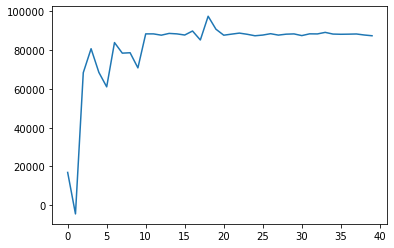

In [13]:
plt.plot(portfolio_value);

In [14]:
portfolio_value[-1]

87458.62310000043